# Лабораторная работа 1

1) Классификация данных методом k ближайших соседей ( kNN)

2) Классификация данных методом опорных векторов (SVM)

3) Построение softmax-классификатора

Вариант 1: задания 1 и 2 на наборе данных CIFAR-10

Вариант 2: задания 1 и 2 на наборе данных MNIST

Вариант 3: задания 1 и 3 на наборе данных CIFAR-10

Вариант 4: задания 1 и 3 на наборе данных MNIST

Лабораторные работы можно выполнять с использованием сервиса Google Colaboratory (https://research.google.com/colaboratory/) или на локальном компьютере.

## 1. Классификация данных методом k ближайших соседей ( kNN)

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scripts.data_utils import load_CIFAR10
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

1.1 Скачайте данные в соответсвии с заданием.

CIFAR-10 по ссылке https://www.cs.toronto.edu/~kriz/cifar.html
или используйте  команду !bash get_datasets.sh (google colab, local ubuntu)

MNIST
from sklearn.datasets import load_digits
digits = load_digits()

In [2]:
 !bash get_datasets.sh

<3>WSL (10) ERROR: CreateProcessEntryCommon:502: execvpe /bin/bash failed 2
<3>WSL (10) ERROR: CreateProcessEntryCommon:505: Create process not expected to return


In [3]:
cifar10_dir = 'datasets/cifar-10-batches-py'

try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

digits = load_digits()
#X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (1347, 64)
Training labels shape:  (1347,)
Test data shape:  (450, 64)
Test labels shape:  (450,)


1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.



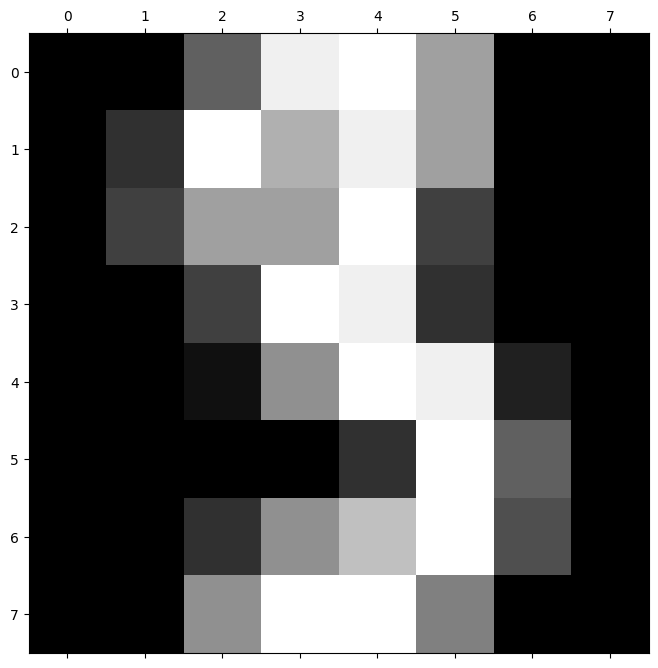

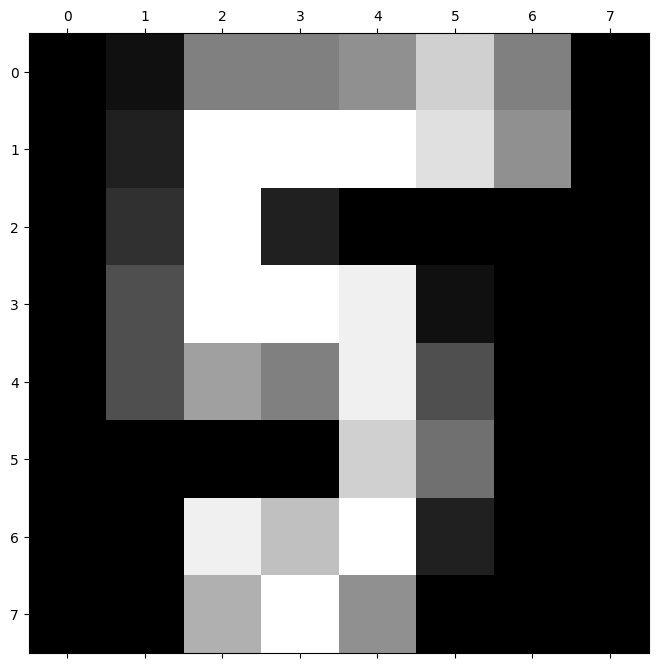

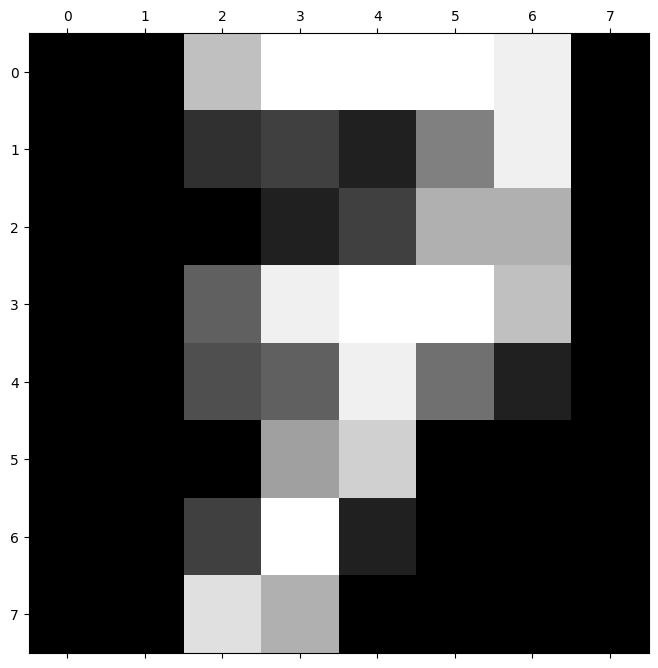

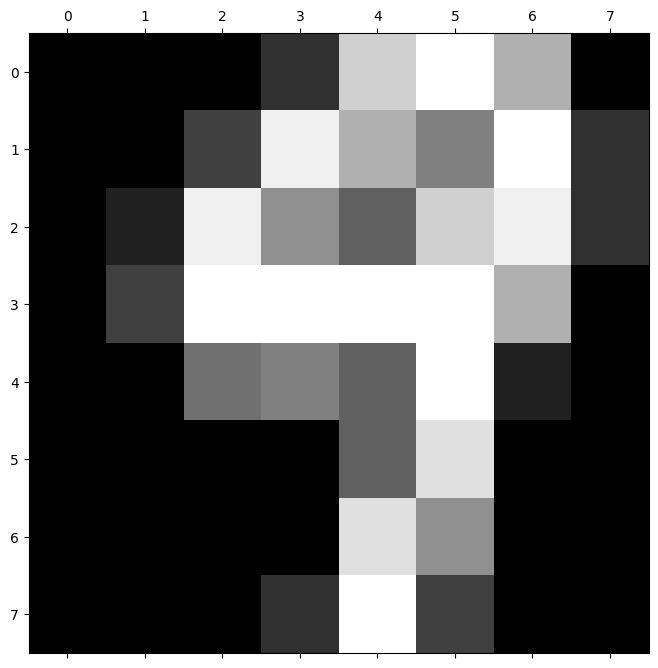

In [4]:
plt.matshow(X_train[0].reshape(8, 8))
plt.matshow(X_train[1].reshape(8, 8))
plt.matshow(X_train[2].reshape(8, 8))
plt.matshow(X_train[3].reshape(8, 8))

1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив.

1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке.

In [5]:
from scripts.classifiers import KNearestNeighbor

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

1.5 Выполните классификацию на тестовой выборке

In [6]:
predicted_labels = classifier.predict(X_test)

1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки.


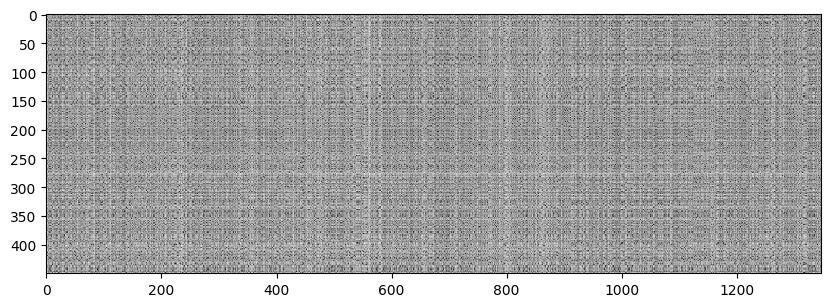

In [7]:
dists = classifier.compute_distances_no_loops(X_test)
plt.imshow(dists)


1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.


In [8]:
np.mean(predicted_labels == y_test)

0.9822222222222222

1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

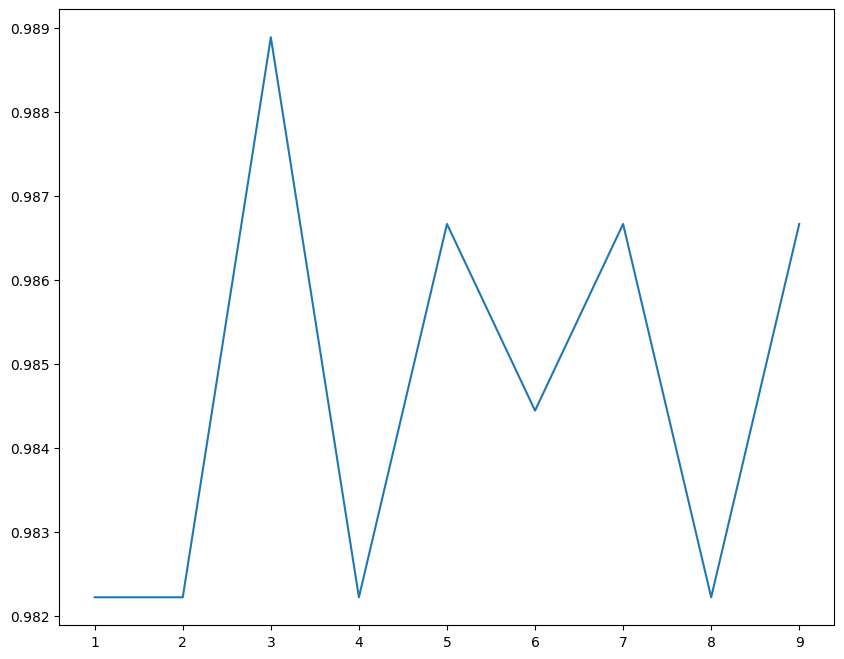

In [9]:
accuracies = list()
for k in range(1, 10):
    predicted_labels = classifier.predict(X_test, k)
    accuracies.append(np.mean(predicted_labels == y_test))
plt.plot(range(1, 10), accuracies)

1.9 Выберите лучшее значение параметра k на основе кросс-валидации.


In [10]:
X = np.split(X_train, [270, 540, 810, 1080])
y = np.split(y_train, [270, 540, 810, 1080])
accuracies = list()
for k in range(1, 10):
    accuracies_k = list()
    for i in range(0, 5):
        X_val = X[i]
        y_val = y[i]
        val_len = X_val.shape[0]
        classifier = KNearestNeighbor()
        classifier.train(np.concatenate((X_train[0:i*val_len], X_train[(i+1)*val_len:])), np.concatenate((y_train[0:i*val_len], y_train[(i+1)*val_len:])))
        predicted_labels = classifier.predict(X_val, k)
        accuracies_k.append(np.mean(predicted_labels == y_val))
    accuracies.append(np.mean(accuracies_k))
best_k = np.argmax(accuracies) + 1


1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.



In [11]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
predicted_labels = classifier.predict(X_test, k=best_k)
np.mean(predicted_labels == y_test)


0.9888888888888889

1.11 Сделайте выводы по результатам 1 части задания.

## 2.  Классификация данных методом опорных векторов (SVM)

2.1 Разделите данные на обучающую, тестовую и валидационную выборки (X_train, y_train, X_test, y_test, X_val, y_val). Создайте также небольшую выборку из обучающей, на которой будет проверяться правильность работы кода (X_dev, y_dev). Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

2.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

2.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву дынных и заполните ее 1.

In [12]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10])
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8'))
plt.show()


X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image


X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])


print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

[0.00000000e+00 3.06607275e-01 5.24350408e+00 1.18849295e+01
 1.17550111e+01 5.78916110e+00 1.37045286e+00 1.28433556e-01
 5.93912398e-03 2.00668151e+00]


ValueError: cannot reshape array of size 64 into shape (32,32,3)

<Figure size 400x400 with 0 Axes>

2.4 Реализуйте loss-функции в scripts/classifiers/linear_svm.py



In [ ]:

from scripts.classifiers.linear_svm import svm_loss_naive
import time


W = np.random.randn(X_train.shape[1], 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))


2.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [ ]:

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

from scripts.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)


loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

2.6 Сравните svm_loss_naive и svm_loss_vectorized реализации

In [ ]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

2.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

In [ ]:
from scripts.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

In [ ]:
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

2.8 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [ ]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

2.9 Сделайте выводы по второй части задания

## 3.  Построение softmax-классификатора

3.1 Разделите данные на обучающую, тестовую и валидационную выборки (X_train, y_train, X_test, y_test, X_val, y_val). Создайте также небольшую выборку из обучающей, на которой будет проверяться правильность работы кода (X_dev, y_dev). Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [ ]:
X_val = X_train[:250]
y_val = y_train[:250]
X_dev = X_train[250:400]
y_dev = y_train[250:400]
X_train = X_train[400:]
y_train = y_train[400:]

print('train size: ', X_train.shape, y_train.shape)
print('test size: ', X_test.shape, y_test.shape)
print('validation size: ', X_val.shape, y_val.shape)
print('dev size: ', X_dev.shape, y_dev.shape)

train size:  (947, 64) (947,)
test size:  (450, 64) (450,)
validation size:  (250, 64) (250,)
dev size:  (150, 64) (150,)


3.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

3.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву данных и заполните ее единицами.

[0.00000000e+00 3.05174234e-01 5.12671595e+00 1.17286167e+01
 1.18310454e+01 5.90073918e+00 1.50052798e+00 1.43611404e-01
 7.39176346e-03 1.89123548e+00]


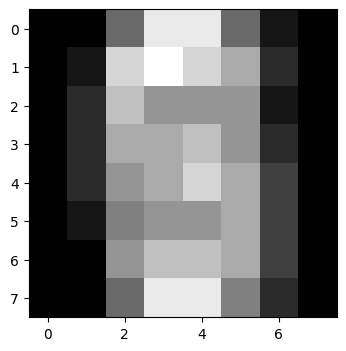

(947, 65) (250, 65) (450, 65) (150, 65)


In [ ]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10])
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((8, 8)).astype('uint8'))
plt.show()


X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image


X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])


print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

3.4 Реализуйте функции в classifiers/softmax.py




In [ ]:
from scripts.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(X_train.shape[1], 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.303280
sanity check: 2.302585


3.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [ ]:
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)


from scripts.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)


loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.823820 analytic: 0.823820, relative error: 4.778229e-11
numerical: 0.013319 analytic: 0.013319, relative error: 5.322328e-10
numerical: 0.300979 analytic: 0.300979, relative error: 1.364110e-10
numerical: 0.493768 analytic: 0.493768, relative error: 1.650029e-10


numerical: 0.025088 analytic: 0.025088, relative error: 7.699993e-10
numerical: -0.000085 analytic: -0.000085, relative error: 1.004595e-08
numerical: 0.203873 analytic: 0.203873, relative error: 9.774333e-11
numerical: 0.185677 analytic: 0.185677, relative error: 6.655880e-11
numerical: 0.071824 analytic: 0.071824, relative error: 2.362685e-10
numerical: -0.004228 analytic: -0.004228, relative error: 5.820051e-09
numerical: 0.005321 analytic: 0.002647, relative error: 3.356900e-01
numerical: -0.005182 analytic: -0.002549, relative error: 3.406244e-01
numerical: 0.082559 analytic: 0.090514, relative error: 4.596485e-02
numerical: -0.133453 analytic: -0.131285, relative error: 8.188518e-03
numerical: -0.006539 analytic: -0.003284, relative error: 3.314217e-01
numerical: 0.587436 analytic: 0.591394, relative error: 3.357607e-03
numerical: 0.001877 analytic: 0.000939, relative error: 3.333333e-01
numerical: -0.092527 analytic: -0.093359, relative error: 4.478877e-03
numerical: -0.048021 a

3.6 Сравните softmax_loss_naive и softmax_loss_vectorized реализации

In [ ]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from scripts.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))


grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.303280e+00 computed in 0.017005s
vectorized loss: 2.303280e+00 computed in 0.001001s
Loss difference: 0.000000
Gradient difference: 0.000000


3.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

In [ ]:
from scripts.classifiers import Softmax
sm = Softmax()
tic = time.time()
loss_hist = sm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 17.001954
iteration 100 / 1500: loss 11.213543
iteration 200 / 1500: loss 7.702107
iteration 300 / 1500: loss 5.574553
iteration 400 / 1500: loss 4.284525


iteration 500 / 1500: loss 3.504568
iteration 600 / 1500: loss 3.029993
iteration 700 / 1500: loss 2.743539
iteration 800 / 1500: loss 2.569274
iteration 900 / 1500: loss 2.464191
iteration 1000 / 1500: loss 2.400287
iteration 1100 / 1500: loss 2.361761
iteration 1200 / 1500: loss 2.338312
iteration 1300 / 1500: loss 2.324209
iteration 1400 / 1500: loss 2.315613
That took 0.679683s


In [ ]:
y_train_pred = sm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = sm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.658923
validation accuracy: 0.608000


3.8 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [ ]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]
accuracies = list()
X = np.split(X_train, [250, 500, 750, 947])
y = np.split(y_train, [250, 500, 750, 947])
for rate in learning_rates:
    for reg in regularization_strengths:
        tmp_accuracies = list()
        for i in range(4):
            X_val = X[i]
            y_val = y[i]
            val_len = X_val.shape[0]
            classifier = Softmax()
            classifier.train(np.concatenate((X_train[0:i*val_len], X_train[(i+1)*val_len:])), 
                            np.concatenate((y_train[0:i*val_len], y_train[(i+1)*val_len:])), 
                            learning_rate=rate, reg=reg)
            predicted_labels = classifier.predict(X_val)
            tmp_accuracies.append(np.mean(predicted_labels == y_val))
        accuracies.append(np.mean(tmp_accuracies))
        print("learning rate: ", rate)
        print("regularization: ", reg)
        print("accuracy", np.mean(tmp_accuracies))


learning rate:  1e-07
regularization:  25000.0
accuracy 0.10791878172588833
learning rate:  1e-07
regularization:  50000.0
accuracy 0.1417258883248731
learning rate:  5e-05
regularization:  25000.0
accuracy 0.7976598984771573
learning rate:  5e-05
regularization:  50000.0
accuracy 0.10618781725888327


In [ ]:
classifier = Softmax()
classifier.train(X_train, y_train, learning_rates[1], regularization_strengths[0])
y_pred = classifier.predict(X_test)
np.mean(y_pred == y_test)

0.8066666666666666

3.9 Сделайте выводы по третьей части задания